In [1]:
import sys
from collections import defaultdict

import cv2
import matplotlib.pyplot as plt
import numpy as np

sys.setrecursionlimit(1500000000)

In [2]:
def merge_ch(image):
    h, w, ch = image.shape
    if ch > 1:
        image = np.mean(image, axis=2)
    return image

In [3]:
def threshold(image, val=0.0, reverse=False):
    h, w, ch = image.shape
    if ch > 1:
        image = np.mean(img, axis=2)

    if reverse:
        background = image[:, :] > val
    else:
        background = image[:, :] < val
        
    image[~background] = 255
    image[background] = 0

    return image

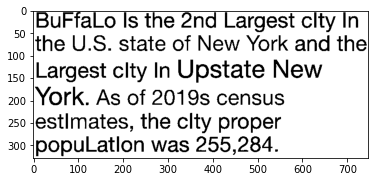

In [63]:
# apply Sauvola local adaptive thresholding
img = cv2.imread('data/test_img.jpg')
bin_img = threshold(img, 100)
_ = plt.imshow(bin_img, cmap='gray')

In [68]:
FOREGROUND = 0.
BACKGROUND = 255.

def get_neighbours(k):
    neighbours = [
        [1, 0],
        [0, 1],
        [-1, 0],
        [0, -1],
    ]
    if k == 8:
        diag_neighbours = [
            [-1, -1],
            [1, 1],
            [-1, 1],
            [1, -1]
        ]
        neighbours += diag_neighbours

    return neighbours

def connected_components(arr, foreground, background, n_dir=8):
    arr = arr.copy()
    height, width = len(arr), len(arr[0])
    components = defaultdict(dict)
    visited = set()
    
    def dfs(i, j, p):
        nonlocal height, width, arr, visited
        if i < 0 or i >= height or j < 0 or j >= width or arr[i][j] == -1 or (i, j) in visited:
            return
       
        visited.add((i, j))
        arr[i][j] = p
        neighbour_idx = get_neighbours(n_dir)
        for x, y in neighbour_idx:
            dfs(i+x, j+y, p)

                
    n_component = 1
    p = 1
    
    for i in range(height):
        for j in range(width):
            if arr[i][j] == background:
                arr[i][j] = -1
    
    for i in range(height):
        for j in range(width):
            if arr[i][j] == foreground:
                dfs(i, j, p)
                p += 1
                
    for i in range(height):
        for j in range(width):
            if arr[i][j] > 0:
                if i < components[arr[i][j]].get('left', float('inf')):
                    components[arr[i][j]]['left'] = i  
                if i > components[arr[i][j]].get('right', float('-inf')):
                    components[arr[i][j]]['right'] = i
                    
                if j < components[arr[i][j]].get('top', float('inf')):
                    components[arr[i][j]]['top'] = j  
                if j > components[arr[i][j]].get('bottom', float('-inf')):
                    components[arr[i][j]]['bottom'] = j
    
                
    return components
                

components = connected_components(
    bin_img,
    foreground=0.,
    background=255.,
)

In [84]:
def get_component(components, idx, img, show=False):
    component = components[idx]
    left, right = component['left'], component['right']
    top, bottom = component['top'], component['bottom']
    
    if show:
        _ = plt.imshow(img[left:right+1, top:bottom+1], cmap='gray')
    
    return img[left:right+1, top:bottom+1]

In [8]:
def gaussian_kernel(size, sigma):
    kernel_1d = np.linspace(- (size // 2), size // 2, size)
    gauss = np.exp(-0.5 * np.square(kernel_1d) / np.square(sigma))
    kernel_2d = np.outer(gauss, gauss)
    return kernel_2d / np.sum(kernel_2d)

In [9]:
def convolve(image, kernel, stride, padding=0):
    img_h, img_w = image.shape
    k_h, k_w = kernel.shape
    h = ((img_h - k_h + (2 * padding)) // stride) + 1
    w = ((img_w - k_w + (2 * padding)) // stride) + 1

    kernel = np.flipud(np.fliplr(kernel))
    output = []
    image = np.pad(image, pad_width=padding)

    for i in range(0, img_h-k_h+1, stride):
        for j in range(0, img_w-k_w+1, stride):
            region = image[i:i+k_h, j:j+k_w]
            output.append(np.multiply(region, kernel).sum())

    output = np.asarray(output).reshape(h, w)
    return output

In [11]:
def gaussian_pyramid(image, n, kernel_len=5, sigma=1):
    image = image.copy()
    res = []
    for i in range(n):
        image = convolve(
            image=image,
            kernel=gaussian_kernel(
                size=kernel_len,
                sigma=sigma,
            ),
            stride=2,
        )
        res.append(image)

    return res

In [12]:
def expand(image, factor=2):
    "Nearest neighbour interpolation"
    img_h, img_w = image.shape
    h, w = img_h * factor, img_w * factor
    output = []

    for i in range(img_h):
        for j in range(img_w):
            for _ in range(factor):
                output.append(image[i][j])
        for _ in range(factor-1):
            output += output[-img_w*factor:]

    output = np.asarray(output).reshape(h, w)
    return output

In [269]:
class Recognition:
    def __init__(self, matcher, measure=None, n=50):
        self.matcher = matcher
        self.bf = cv2.BFMatcher()
        self.n = n
        
    def match(self, img1, img2):
        score = 0
        img1_g = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
        kp_1, dsc_1 = self.matcher.detectAndCompute(img1_g, None)
        
        img2_g = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
        kp_2, dsc_2 = self.matcher.detectAndCompute(img2_g, None)
        
        matches = self.bf.match(dsc_1, dsc_2)
        matches = sorted(matches, key = lambda x:x.distance)

        if matches:
            dist = sum([match.distance for match in matches[:self.n+1]])
            if dist == 0:
                score = 100
            else:
                score = ((self.n+1)/dist) * 100
        img = cv2.drawMatches(img1, kp_1, img2, kp_2, matches[:self.n+1], None, flags=2)
        
        return matches, score, img
    
sift = cv2.SIFT_create()
orb = cv2.ORB_create()

recog_sift = Recognition(sift, n=10)
recog_orb = Recognition(orb, n=10)

In [273]:
a = cv2.imread('data/characters/a.jpg')
# _ = plt.imshow(a, cmap='gray')

In [274]:
dot = cv2.imread('data/characters/dot.jpg')
# _ = plt.imshow(dot, cmap='gray')

In [275]:
c = cv2.imread('data/characters/c.jpg')
# _ = plt.imshow(c, cmap='gray')

In [276]:
e = cv2.imread('data/characters/e.jpg')
# _ = plt.imshow(e, cmap='gray')

In [277]:
two = cv2.imread('data/characters/2.jpg')
# _ = plt.imshow(two, cmap='gray')

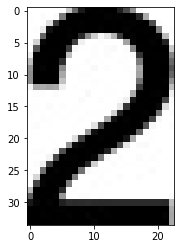

In [278]:
two_t = get_component(components, 7, img, show=True)

0.640500203137157


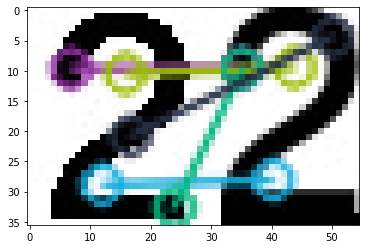

In [279]:
_, score, im = recog_sift.match(two, two_t)
print(score)
_ = plt.imshow(im, cmap='gray')

0.21085577547557002


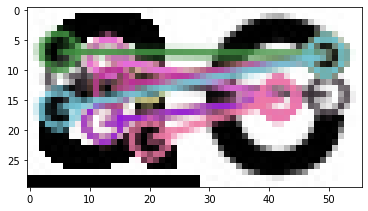

In [280]:
_, score, im = recog_sift.match(a, c)
print(score)
_ = plt.imshow(im, cmap='gray')

0.24684896692432173


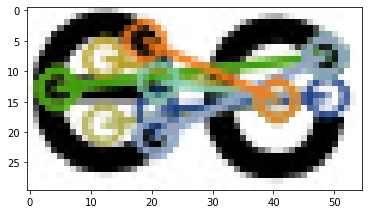

In [271]:
_, score, im = recog_sift.match(e, c)
print(score)
_ = plt.imshow(im, cmap='gray')

100


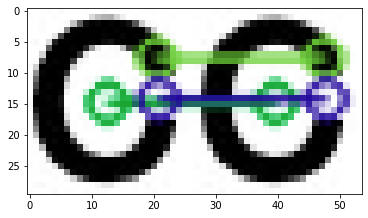

In [272]:
_, score, im = recog_sift.match(c, c)
print(score)
_ = plt.imshow(im, cmap='gray')